In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

#Importamos random para obtener coordenadas al azar
import random
import math

#TYPES
#Type 1 Food
#Type 2 deposit 

In [2]:
class FoodAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.has_food = False
        self.deposit_coordinates = None # Inicialmente no se conocen las coordenadas del depósito
        self.food_coordinates = None  # Coordenadas para dirigirse a comida
        self.random.seed(12345)
#el método step del agente, se utiliza esta función para intentar obtener las coordenadas de la comida. 
#Si el agente no tiene comida, intentará moverse hacia la comida si hay coordenadas disponibles.

    def step(self):

        print("xd1")
        #Obtenemos las posibles celdas a las que el agente se puede mover
        neighborhood = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)

        # Se filtran las celdas vacías entre las celdas vecinas
        empty_cells = [cell for cell in neighborhood if (self.model.grid.is_cell_empty(cell) and self.model.get_type(cell[0], cell[1]) == 0)]                                                     
        
        # Se filtran las celdas de comida 
        food_cells = [cell for cell in neighborhood if (self.model.grid.is_cell_empty(cell) and self.model.get_type(cell[0], cell[1]) == 1)]     
    
         # Se filtra la celda de depósito
        deposit_cell = [cell for cell in neighborhood if (self.model.grid.is_cell_empty(cell) and self.model.get_type(cell[0], cell[1]) == 2)] 

        print("empty Cell:", empty_cells)
        print("food Cell:", food_cells)
        print("Deposit Cell:", deposit_cell)

        # Actualiza las coordenadas del deposito en el modelo en caso de que esté en su vecindario
        if deposit_cell:            # Print the coordinates for further debugging
            deposit_coordinates = deposit_cell[0]
            print("Deposit Coordinates:", deposit_coordinates)

            # Assuming deposit_coordinates is a tuple (x, y)
            self.model.update_deposit_coordinates(deposit_coordinates[0], deposit_coordinates[1])
            
        # Actualiza las coordenadas de la comida en el modelo en caso de que haya comida en su vecindario
        if food_cells:
            self.model.update_food_coordinates(food_cells)

        #El agente hace un a llamada para obtener las coordenadas en caso de que se hayan guardado en el array
        if self.deposit_coordinates is None:
            self.deposit_coordinates = self.model.get_deposit_coordinates()


            # Si el agente no tiene comida
        if not self.has_food:
            food_moves = self.model.get_food_coordinates(self.pos[0], self.pos[1])
            print("Type:", self.model.get_type(self.pos[0], self.pos[1]))

            # Si la celda actual tiene comida y no es un depósito, recoge la comida                 
            if self.model.get_type(self.pos[0], self.pos[1]) == 1:
                print("xd8")
                self.model.take_food(self.pos[0], self.pos[1])
                self.has_food = True

                # Si hay coordenadas del depósito, muévete hacia el depósito
                if self.deposit_coordinates is not None:
                    print("xd9")
                    self.move_to_deposit(empty_cells)

                else:
                    self.model.grid.move_agent(self, self.random.choice(empty_cells))

            # Si hay celdas con comida en el vecindario mueve el agente hacia allá
            elif food_cells:
                print("xd10") 

                food_cell = self.random.choice(food_cells)
                print("food Type:", self.model.get_type(food_cell[0], food_cell[1]))
            
                self.model.grid.move_agent(self, food_cell)

            # Si no hay celdas con comida en el vecindario el agente busca si hay coordenadas guardas en el array y si hay se mueve  
            elif food_moves:
                print("xd11") 
                self.food_coordinates = food_moves

                print("Food coordinates:  " + str(self.food_coordinates))
                self.move_to_food(empty_cells)

            #Si ninguna de estas es verdadera, mueve el agente a una posición random en empty cells
            else:
                print("xd12") 
                self.model.grid.move_agent(self, self.random.choice(empty_cells))               

        #Si el agente tiene comida
        else:
            print("hola")
            #Si el agente está actualmente en el deposito, coloca la comida
            if self.model.get_type(self.pos[0], self.pos[1]) == 2:
                self.model.place_food()
                self.has_food = False
            
            #Si no esta pero tiene las coordenadas que se mueva a las coordenadas
            elif self.deposit_coordinates is not None:
                self.move_to_deposit(empty_cells)

            #Si no hya coordenadas de deposito muevete a una celda vacía     
            else:
                self.model.grid.move_agent(self, self.random.choice(empty_cells))

    # Mueve al agente hacia el depósito utilizando la distancia de Manhattan.
    def move_to_deposit(self, empty_cells):
        """
        Move the agent towards the position of the deposit using Manhattan distance.
        """
        print("Entering move_to_deposit")
        if self.deposit_coordinates is not None:
            print(f"Current position: {self.pos}")
            deposit_row, deposit_col = self.deposit_coordinates
            current_row, current_col = self.pos

            delta_row = 0
            delta_col = 0

            # Calculate Manhattan distance
            x = deposit_row - current_row
            y = deposit_col - current_col

            print(f"Delta x: {x}, Delta y: {y}")

            # Check the preferred direction (x or y) based on the greater distance
            if abs(x) > abs(y):
                delta_row = int(math.copysign(1, x))
            else:
                delta_col = int(math.copysign(1, y))

            print(f"Delta Row: {delta_row}, Delta Col: {delta_col}")

            # Calculate the new position
            new_row = int(current_row + delta_row)
            new_col = int(current_col + delta_col)
            new_position = (new_row, new_col)

            print(f"New position before check: {new_position}")

            # Attempt to move to an empty cell in the neighborhood
            if self.model.grid.is_cell_empty(new_position):
                print(f"Moving to new position: {new_position}")
                self.model.grid.move_agent(self, new_position)
            else:
                print(f"New position {new_position} is not empty. Moving to empty cell.")
                self.model.grid.move_agent(self, self.random.choice(empty_cells))

    def move_to_food(self, empty_cells):
        """
        Mueve al agente hacia la posición de la comida utilizando la distancia de Manhattan.
        La distancia de Manhattan se define como la suma de las diferencias absolutas de las coordenadas en cada dimensión
        d = |x1 - x2| + |y1 - y2|
        """
        print("Entering move_to_food")
        if self.food_coordinates is not None:
            print(f"Current position: {self.pos}")
            food_row, food_col = self.food_coordinates
            current_row, current_col = self.pos

            delta_row = 0
            delta_col = 0

            # Calcula la distancia de Manhattan
            x = food_row - current_row
            y = food_col - current_col

            print(f"Delta x: {x}, Delta y: {y}")

            # Comprueba la dirección preferida (x o y) basándose en la distancia mayor
            if abs(x) > abs(y):
                delta_row = int(math.copysign(1, x))
            else:
                delta_col = int(math.copysign(1, y))

            print(f"Delta Row: {delta_row}, Delta Col: {delta_col}")

            # Mueve al agente solo un paso en la dirección preferida
            new_row = int(current_row + delta_row)
            new_col = int(current_col + delta_col)
            new_position = (new_row, new_col)

            print(f"New position before check: {new_position}")

            # Verifica si la nueva posición es válida antes de realizar el movimiento
            if self.model.grid.is_cell_empty(new_position):
                print(f"Moving to new position: {new_position}")
                self.model.grid.move_agent(self, new_position)
            else:
                print(f"New position {new_position} is not empty. meoving to empty cell.")
                self.model.grid.move_agent(self, self.random.choice(empty_cells))


In [3]:
#En get_grid obtenemos los contenidos de nuestra celda y seteamos valores numéricos
#para después setear los colores en el grid

def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height), dtype=int)
    
    for (content, (x, y)) in model.grid.coord_iter():

        if content:
            grid[x][y] = 1   #Agent

        elif model.get_type(x, y) == 1: 
            grid[x][y] = 2  #Comida

        elif model.get_type(x, y) == 2: 
            grid[x][y] = 3 #Deposito

        else:
            grid[x][y] = 0  # Empty cell

    return grid


In [4]:
class FoodModel(Model):
    def __init__ (self, width, height, num_agents, num_food):
        super().__init__(width, height)
        self.num_food = num_food
        self.food_in_deposit = 0
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})  
        self.type = np.zeros((width, height))
        self.deposit_coordinates = None
        self.food_coordinates = []
        self.is_deposit = np.zeros((width, height))
        self.running = True
        self.step_call_count = 0
        self.random.seed(12345)
        
        #añadimos
        #una id única a los agentes

        #self.type  = 0 vacío
        #self.type  = 1 comida
        #self.type  = 2 deposito

        id = 0

        #Iniciamos variables en cero
        for x in range(width):
            for y in range(height):
                self.type[x][y] = 0

        #Ponemos agentes en random
        for i in range(num_agents):
            x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)

            while not (self.grid.is_cell_empty((x, y))):
                 x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)    
            
            fooder = FoodAgent(id, self)
            self.grid.place_agent(fooder, (x, y))
            self.schedule.add(fooder)
            id = id + 1

        #Ponemos coordenadas del deposito random
        x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)
        while not (self.grid.is_cell_empty((x, y))):
                 x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)
        if (self.grid.is_cell_empty((x, y))):
                self.type[x][y] = 2

    def step(self):

        #Checamos que haya coordenadas de deposito y que este haya alcanzada type 47
        self.step_call_count += 1

        print("step")
        print(self.step_call_count)

        if(self.step_call_count % 5 == 0):
            print("creando comida")
            self.generate_food()  

        print("comida en grid: ")
        print(np.sum(self.type == 1))  
        
        print("food in deposit: " + str(self.food_in_deposit))
        self.datacollector.collect(self)
        self.schedule.step() 

        if self.food_in_deposit == 47:
            self.running = False

    def get_type(self, x,y):
        return self.type[x][y]
         
    def generate_food(self):

        #Esta función cuenta la cantidad de comida, y elige un número random para setear celdas con una unidad de comida  
        if self.num_food > 0:     

            if self.num_food >= 5:
                cell_quantity = self.random.randint(2,5) 
            
            elif self.num_food == 4:
                cell_quantity = self.random.randint(2,4) 

            elif self.num_food == 3:
                cell_quantity = self.random.randint(2,3) 

            elif self.num_food == 2:
                cell_quantity = self.random.randint(1,2) 
            
            else:
                cell_quantity = 1

            print("cell_quantity")
            print(cell_quantity)

            self.num_food -= cell_quantity

            print("self.num_food")
            print(self.num_food)

            for i in range(cell_quantity):      
                x, y = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
                while not (self.grid.is_cell_empty((x, y)) and self.get_type(x,y)== 0 ):
                    x, y = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height) 

                self.type[x][y] = 1


    def update_deposit_coordinates(self, x, y):

        if x is not None and y is not None:
            self.deposit_coordinates = (x, y)

    #El modelo recibe un array de comida encontrada en el vecindario del agente, solo va a agregar aquellas coordenadas que no tiene
    def update_food_coordinates(self, cells):
        if cells:
            for cell in cells:
                x, y = cell
                if (x, y) not in self.food_coordinates:
                    self.food_coordinates.append((x, y))

    # Cada vez que el agente toma comida. se borra la coordenada de, array en caso de que se encuentre
    def take_food(self, x, y):
        self.type[x][y] -= 1
        
        if (x, y) in self.food_coordinates:
            self.food_coordinates.remove((x, y))

    def place_food(self):
        self.food_in_deposit += 1
        
    def get_food_coordinates(self, x, y):
        """
        Devuelve las coordenadas de la comida más cercana al agente.

        Parameters:
            current_position: Tupla (x, y) que representa la posición actual del agente.

        Returns:
            Tupla (x, y) de las coordenadas de la comida más cercana o None si no hay comida en el vecindario.
        """
        if not self.food_coordinates:
            return None
        
        current_position = (x,y)

        # Calcula las distancias de Manhattan entre la posición actual del agente y las coordenadas de la comida
        distances = [abs(current_position[0] - food[0]) + abs(current_position[1] - food[1]) for food in self.food_coordinates]

        # Encuentra el índice de la comida más cercana
        closest_food_index = np.argmin(distances)

        # Devuelve las coordenadas de la comida más cercana
        return self.food_coordinates[closest_food_index]
    
    def get_deposit_coordinates(self):
        # Guarda las coordenadas en el arreglo food_coordinates
        return self.deposit_coordinates
    

In [5]:
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5
NUM_FOOD = 47

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()

model = FoodModel(WIDTH, HEIGHT, NUM_AGENTS, NUM_FOOD)
step_counter = 0 
#llamamos al modelo y contamos los steps hasta que acabe
while model.running:
    model.step()
    step_counter += 1

# Imprimimos el tiempo que le tomó correr al modelo.
print('Numero de pasos:', step_counter)
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

step
1
comida en grid: 
0
food in deposit: 0
xd1
empty Cell: [(17, 4), (17, 5), (17, 6), (18, 4), (18, 6), (19, 4), (19, 5), (19, 6)]
food Cell: []
Deposit Cell: []
Type: 0.0
xd12
xd1
empty Cell: [(1, 0), (1, 1), (2, 1), (3, 0), (3, 1)]
food Cell: []
Deposit Cell: []
Type: 0.0
xd12
xd1
empty Cell: [(16, 16), (16, 17), (16, 18), (17, 16), (17, 18), (18, 16), (18, 17), (18, 18)]
food Cell: []
Deposit Cell: []
Type: 0.0
xd12
xd1
empty Cell: [(18, 6), (18, 7), (18, 8), (19, 6), (19, 8)]
food Cell: []
Deposit Cell: []
Type: 0.0
xd12
xd1
empty Cell: [(2, 12), (2, 13), (2, 14), (3, 12), (3, 14), (4, 12), (4, 13), (4, 14)]
food Cell: []
Deposit Cell: []
Type: 0.0
xd12
step
2
comida en grid: 
0
food in deposit: 0
xd1
empty Cell: [(1, 0), (1, 1), (1, 2), (2, 0), (2, 2), (3, 0), (3, 1), (3, 2)]
food Cell: []
Deposit Cell: []
Type: 0.0
xd12
xd1
empty Cell: [(17, 3), (17, 4), (17, 5), (18, 3), (18, 5), (19, 3), (19, 4), (19, 5)]
food Cell: []
Deposit Cell: []
Type: 0.0
xd12
xd1
empty Cell: [(17, 16

In [6]:
#Recolectamos los datos del grid 
all_grid = model.datacollector.get_model_vars_dataframe()

C:\Users\cgare\AppData\Local\Temp\ipykernel_6172\3136879400.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=3)
C:\Users\cgare\AppData\Local\Temp\ipykernel_6172\3136879400.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


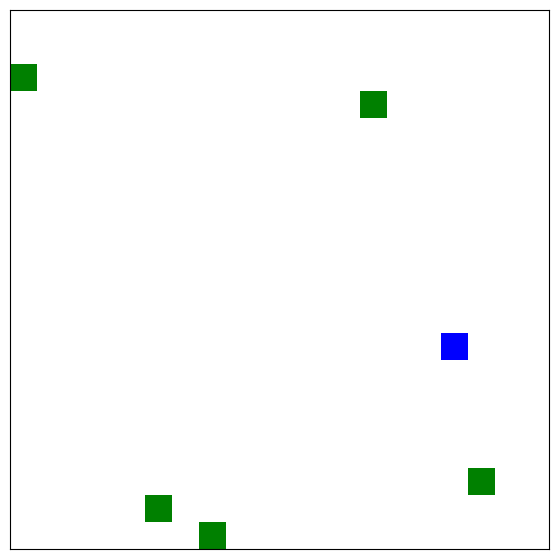

In [7]:

fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])

# Definimos el color para la distinguir agentes, y celdas con comida y deposito
#el numero que seteamos anteriormente corresponde al valor del array
#de colores que queremos que se muestre 
cmap = plt.cm.colors.ListedColormap(['white', 'green', 'red', 'blue'])

patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=3)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    patch.set_clim(vmin=0, vmax=3)  #establecemos los limites del color

anim = animation.FuncAnimation(fig, animate, frames=step_counter)

In [8]:
anim

C:\Users\cgare\AppData\Local\Temp\ipykernel_6172\3136879400.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])
